In [ ]:
!pip install -q kaggle

Acesse https://www.kaggle.com/ e crie sua conta. Entre nas configurações da sua conta e clique em Create New Token. Faça o upload do arquivo usando o código abaixo.

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lgmoneda/br-coins

mkdir: cannot create directory ‘/root/.kaggle’: File exists
br-coins.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/br-coins.zip

Archive:  /content/br-coins.zip
replace COCO_labelme_classification/classification/100_1477154436.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import glob as glob
import os

import cv2 as cv
from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

In [ ]:
IMAGES_DIR = 'COCO_labelme_classification/classification'

IMAGE_PATHS = glob.glob(f"{IMAGES_DIR}/*.jpg")
ALL_IMAGES = [image_path.split(os.path.sep)[-1] for image_path in IMAGE_PATHS]

TRAIN_IMAGES, VALIDATION_IMAGES = torch.utils.data.random_split(ALL_IMAGES, [0.8, 0.2])

Na célula abaixo desenvolveremos o código para detectar uma moeda usando HOG e SVM.

In [ ]:
CLASS_N = 6
CLASSES = ["__background__", "__coin__"]
COIN_W, COIN_H = 120, 120
IMAGE_W, IMAGE_H = (640 // COIN_W) * COIN_W, (480 // COIN_H) * COIN_H

def sliding_window(img, w, h):
    tiles = []
    boxes = []

# Abaixo você deve escrever o código para escanear toda a janela
# e retornar as janelas de tamanhao (w, h) e as 4 coordenadas que
# determinam a posicção desssa janela.
################################################
# SEU CODIGO
################################################

    return tiles, boxes


def getitem(dir_name, image_name, width, height):
    image_path = os.path.join(dir_name, image_name)

    image = cv.imread(image_path)
    image_resized = cv.resize(image, (width, height))

    boxes = []
    labels = []

    annot_filename = image_name[:-4] + '.json'
    annot_file_path = os.path.join(dir_name, annot_filename)
    with open(annot_file_path) as my_file:
      annot_boxes = json.loads(my_file.read())

    image_width = image.shape[1]
    image_height = image.shape[0]

# Redimensione a imagem atual por width e height, percorra as anotações
# para achar criar os vetores boxes e labels. boxes deve guardar as coordenadas de cada objeto na imagem
# e label deve guardar a clase do objeto
################################################
# SEU CODIGO
################################################

    target = {}
    target["boxes"] =  boxes
    target["labels"] = labels
    return image_resized, target


def get_hog() :
    winSize = (COIN_W, COIN_H)
    blockSize = (48, 48)
    blockStride = (24,24)
    cellSize = (48, 48)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    return cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)



def find_intersection(boxes, b):
    for i in range(len(boxes)):
        box = boxes[i]

# Calcule a iou de b para todas as boxes.
# retorne o indice quando iou for maior q 0.8
################################################
# SEU CODIGO
################################################

    return -1


print('Defining HoG parameters ...')
# HoG feature descriptor
hog = get_hog();

print('Calculating HoG descriptor for every image ... ')
positive_hog, positive_labels = [], []
negative_hog, negative_labels = [], []
for img_name in TRAIN_IMAGES:
    img, target = getitem(IMAGES_DIR, img_name, IMAGE_W, IMAGE_H)
    if len(target["labels"]) <= 0:
        continue

    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    tiles, boxes = sliding_window(img, COIN_W, COIN_H)
    for tile, box in zip(tiles, boxes):
        xmin, xmax, ymin, ymax = box
        idx = find_intersection(target["boxes"], box)
        if idx != -1:
            label = target["labels"][idx]
            positive_hog.append(hog.compute(tile))
            positive_labels.append(label)
        else:
            negative_hog.append(hog.compute(tile))
            negative_labels.append(CLASSES.index("__background__"))

negative_labels = negative_labels[:len(positive_hog)]
negative_hog = negative_hog[:len(positive_labels)]


hog_train = np.squeeze(positive_hog + negative_hog)
labels_train = np.array(positive_labels + negative_labels)
print(hog_train.shape, labels_train.shape)


Defining HoG parameters ...
Calculating HoG descriptor for every image ... 
hog_descriptors_train: 202
negative_hog: 202
TRAIN_IMAGES: 2445
(404, 144) (404,)


In [ ]:
gamma = 1/len(hog_descriptors_train[0])

def svmInit(C=0.5, gamma=0.50625):
    model = cv.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv.ml.SVM_RBF)
    model.setType(cv.ml.SVM_C_SVC)

    return model

print('Training SVM model ...')
model = svmInit(gamma = gamma)
model.train(hog_train, cv.ml.ROW_SAMPLE, labels_train)

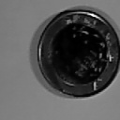

120 240 60 180


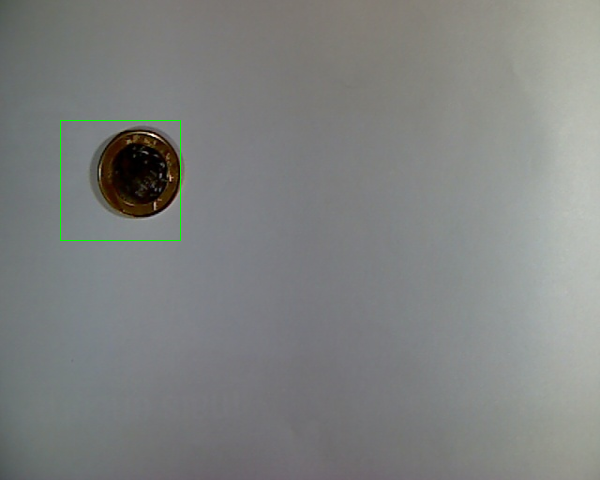

In [ ]:
def non_max_suppression(boxes, overlapThresh):
    pick = []
# crie um algoritmo de non_max_suppression que
# delete as boxes com iou maior que overlapThresh
# use
################################################
# SEU CODIGO
################################################
    return boxes[pick].astype("int")

image_number = 4

img, target = getitem(IMAGES_DIR, VALIDATION_IMAGES[image_number], IMAGE_W, IMAGE_H)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
tiles, boxes = sliding_window(gray, COIN_W, COIN_H)

hog_descriptors_predict = [hog.compute(t) for t in tiles]

hog_descriptors_predict = np.squeeze(hog_descriptors_predict)

predicts = model.predict(hog_descriptors_predict)[1].ravel()

bs = []
for t, p, b in zip(tiles, predicts, boxes):
    if CLASSES[int(p)] == "__coin__":
        bs.append(b)
        cv2_imshow(t)

bs = np.array(bs)
bs = non_max_suppression(bs, 0.2)

for xi, xf, yi, yf in bs:
    print(xi, xf, yi, yf)
    img = cv.rectangle(img, (yi, xi), (yf, xf), (0, 255, 0))
cv2_imshow(img)

In [ ]:
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq

COIN_W, COIN_H = 120, 120
IMAGE_W, IMAGE_H = (640 // COIN_W) * COIN_W, (480 // COIN_H) * COIN_H

positive_keypoints, positive_descriptors, positive_labels = [], [], []
negative_keypoints, negative_descriptors, negative_labels = [], [], []
bw_images, color_images = [], []
labels = []

sift = cv.SIFT_create()
for img_name in TRAIN_IMAGES:

    img, target = getitem(IMAGES_DIR, img_name, IMAGE_W, IMAGE_H)
    if len(target["labels"]) <= 0:
        continue

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kps, ds = sift.detectAndCompute(gray, None)
    positive_labels.append(CLASSES.index("__coin__"))
    positive_keypoints.append(kps)
    positive_descriptors.append(ds)
    bw_images.append(gray)
    color_images.append(img)
    labels.append(img_name.split("_")[0])

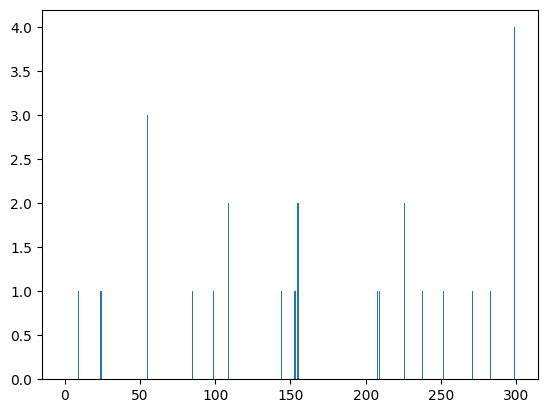

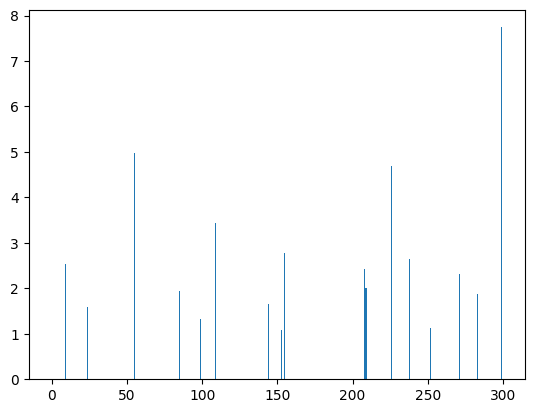

In [ ]:
#################################
# SEU CODIGO
#################################


#################################
# SEU CODIGO
#################################

visual_words = []
for img_descriptors in positive_descriptors:
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

frequency_vectors = []
for img_visual_words in visual_words:
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)

frequency_vectors = np.stack(frequency_vectors)

plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

N = len(TRAIN_IMAGES)
df = np.sum(frequency_vectors > 0, axis=0)
idf = np.log(N/ df)
tfidf = frequency_vectors * idf

plt.bar(list(range(k)), tfidf[0])
plt.show()

250: 1.0 label: 25


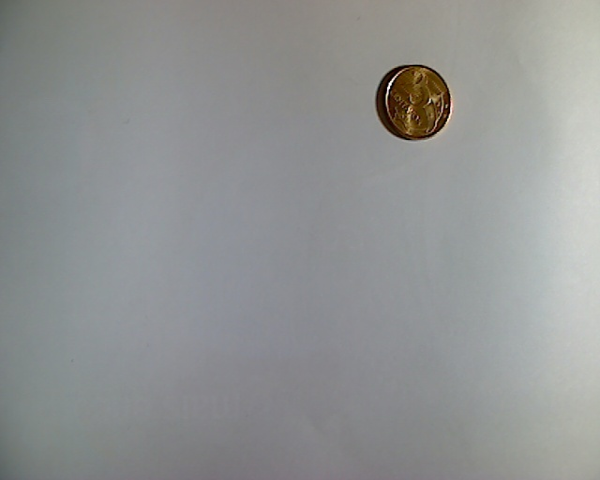

2003: 0.4339 label: 25


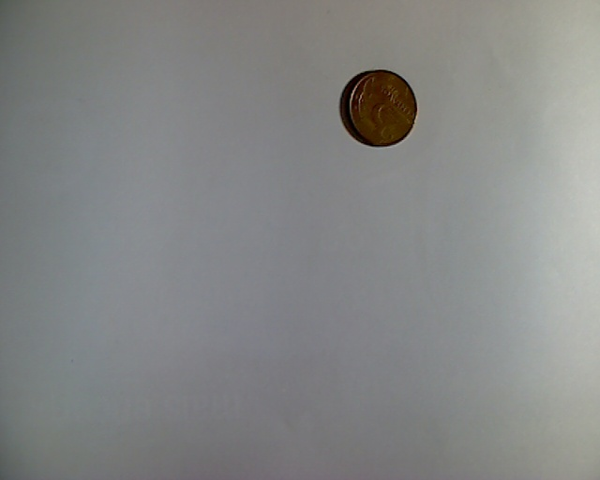

465: 0.4194 label: 100


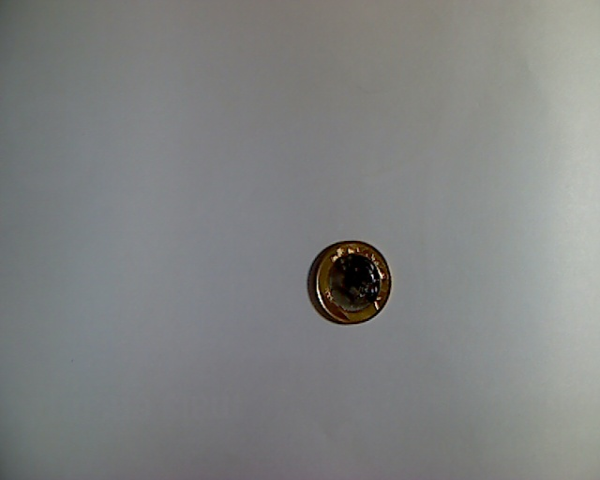

240: 0.4098 label: 10


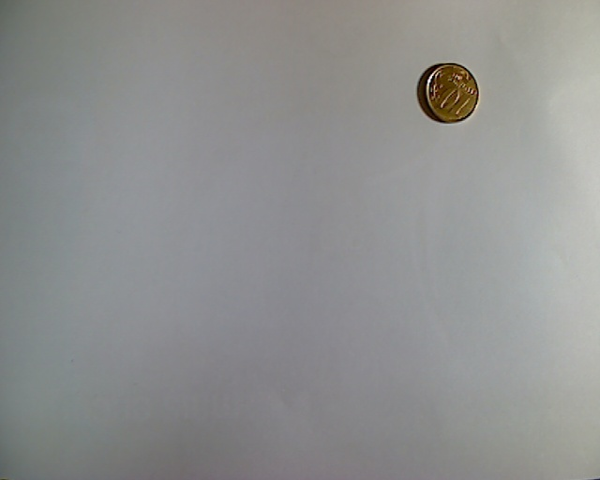

1789: 0.3976 label: 25


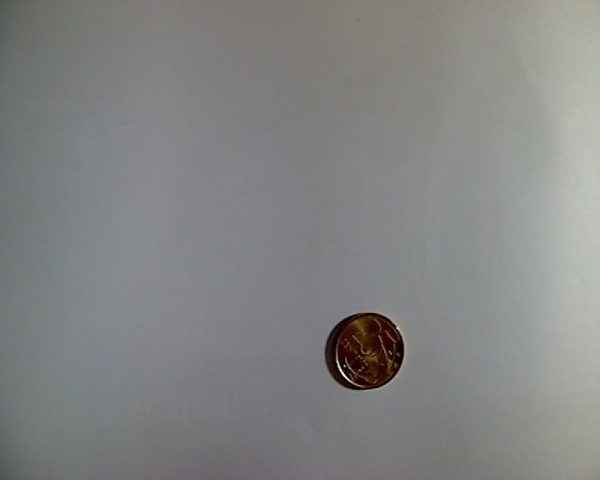

In [ ]:
from numpy.linalg import norm

top_k = 5
i = 250

# get search image vector
a = tfidf[i]
b = tfidf  # set search space to the full sample
# get the cosine distance for the search image `a`
cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
# get the top k indices for most similar vecs
idx = np.argsort(-cosine_similarity)[:top_k]
# display the results
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)} label: {labels[i]}")
    cv2_imshow(color_images[i])

In [ ]:
###################
# OPTICAL FLOW
###################
cap = cv.VideoCapture("/content/video.avi")
points = [287, 139, 40, 44]

lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))


ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

p0 = []
# Use o sift para adquirir caracteristicas da janela definida em points (x, y, w, h).
# depois disso guarde os pontos das caracteristicas em p0
###############################
# CODIGO
##############################

size = (int(cap.get(3)), int(cap.get(4)))
result = cv.VideoWriter('filename.avi', cv.VideoWriter_fourcc(*'MJPG'),10, size)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    p1 = []
    # use o algoritmo de opticalflow para determinar os proximos pontos e guarde-os em p1
    # desenhe os pontos na imagem
    ###############################
    # CODIGO
    ##############################

    old_gray = frame_gray.copy()
    p0 = p1.reshape(-1, 1, 2)

No frames grabbed!


In [ ]:
###########
# CAMSHIFT
###########
cap = cv.VideoCapture("/content/video.avi")
points = [287, 139, 40, 44]
track_window = (points)

ret, frame = cap.read()

roi_hist = None
# Calcule o histograma normalizado da regiao de interessse definida em points
# guarde em roi_hist
###############################
# CODIGO
##############################

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

size = (int(cap.get(3)), int(cap.get(4)))
result = cv.VideoWriter('filename2.avi', cv.VideoWriter_fourcc(*'MJPG'),10, size)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    if ret == True:
        img2 = None
        # Calcule a reprojeção do histograma nromalizado e use os resultados em camshift
        # desenhe o retangulo na imagem
        ###############################
        # CODIGO
        ##############################

        result.write(img2)

No frames grabbed!
